## 

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#2ae4f5''></span></b> Forecasting Life Expectancy By Regression </b></p>
</div>

## <b>2 <span style='color:#2ae4f5'>|</span> Import Libraries </b> 

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

## <b>3 <span style='color:#2ae4f5'>|</span> Import Dataset </b> 

In [4]:
# Import dataset
train_data = pd.read_csv("C:\TY IT\Sem - 2\ML\Projects\life_expectancy.csv")
train_data.head()

,Country,Year,Status,Population,Hepatitis B,Measles,Polio,Diphtheria,HIV/AIDS,infant deaths,under-five deaths,Total expenditure,GDP,BMI,thinness 1-19 years,Alcohol,Schooling,Life expectancy
0,Afghanistan,2015,Developing,33736494.0,65.0,1154,6.0,65.0,0.1,62,83,8.16,584.259210,19.1,17.2,0.01,10.1,65.0
1,Afghanistan,2014,Developing,327582.0,62.0,492,58.0,62.0,0.1,64,86,8.18,612.696514,18.6,17.5,0.01,10.0,59.9
2,Afghanistan,2013,Developing,31731688.0,64.0,430,62.0,64.0,0.1,66,89,8.13,631.744976,18.1,17.7,0.01,9.9,59.9
3,Afghanistan,2012,Developing,3696958.0,67.0,2787,67.0,67.0,0.1,69,93,8.52,669.959000,17.6,17.9,0.01,9.8,59.5
4,Afghanistan,2011,Developing,2978599.0,68.0,3013,68.0,68.0,0.1,71,97,7.87,63.537231,17.2,18.2,0.01,9.5,59.2


In [5]:
# More details about dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               2848 non-null   object 
 1   Year                  2848 non-null   int64  
 2   Status                2848 non-null   object 
 3   Population            2204 non-null   float64
 4   Hepatitis B           2306 non-null   float64
 5   Measles               2848 non-null   int64  
 6   Polio                 2829 non-null   float64
 7   Diphtheria            2829 non-null   float64
 8   HIV/AIDS              2848 non-null   float64
 9   infant deaths         2848 non-null   int64  
 10  under-five deaths     2848 non-null   int64  
 11  Total expenditure     2627 non-null   float64
 12  GDP                   2406 non-null   float64
 13  BMI                   2816 non-null   float64
 14  thinness  1-19 years  2816 non-null   float64
 15  Alcohol              


## <b>4 <span style='color:#2ae4f5'>|</span> Visualization </b> 

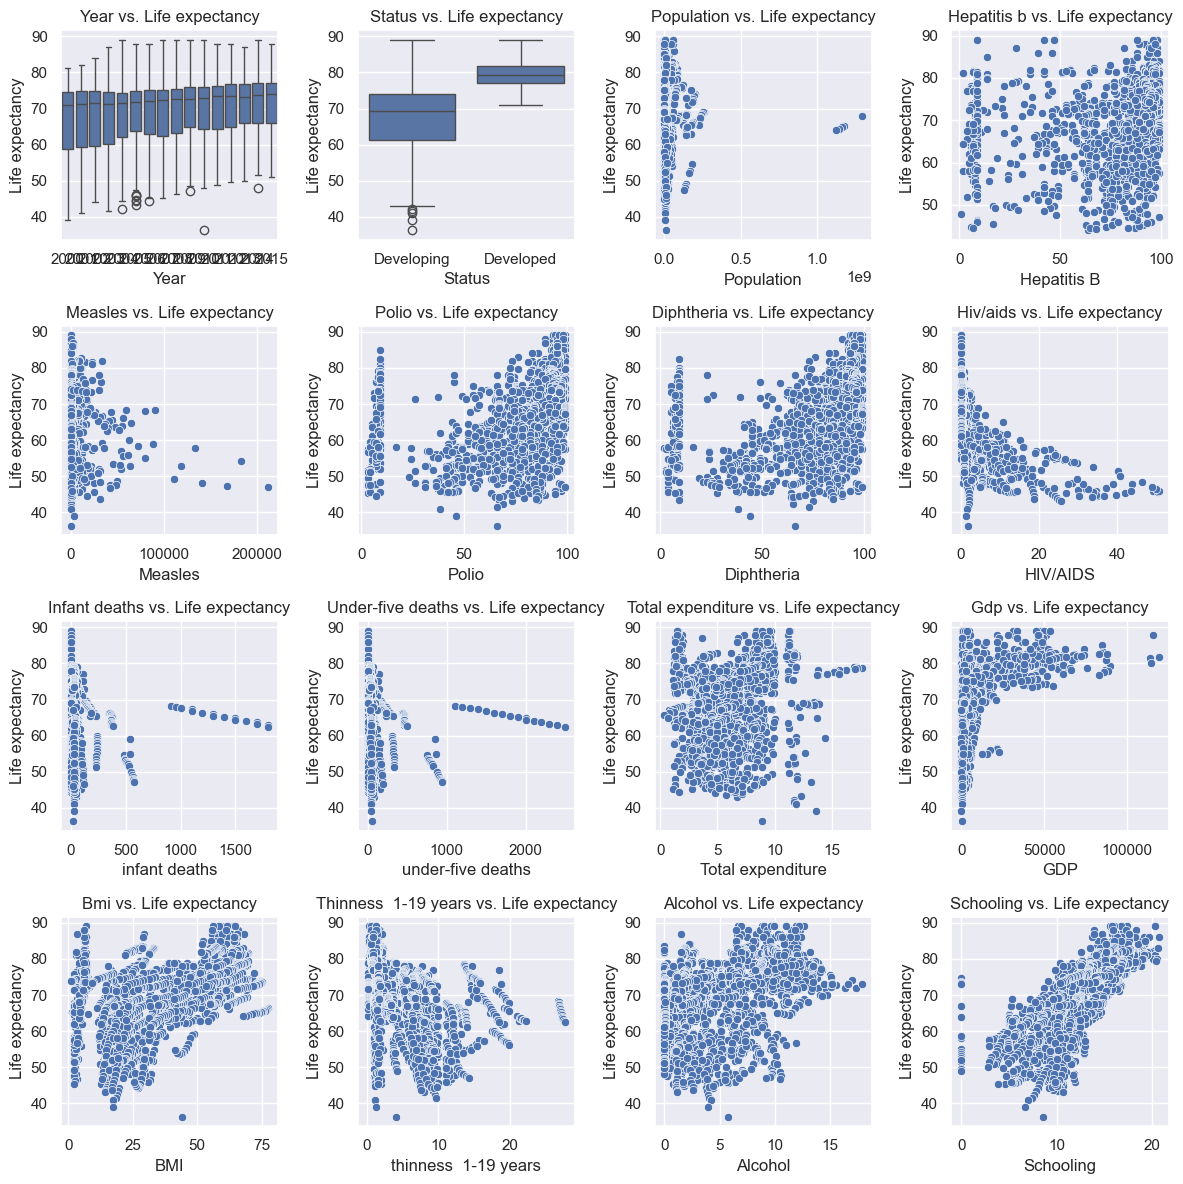

In [6]:
# Exploring Relationships between Variables and Life Expectancy

class RelationshipPlotter:
    
    def __init__(self, data):
        self.data = data
        self.fig, self.axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))  # Create a 4x4 subplot grid
    
    def plot(self, row, col, x, y, plot_type):
        ax = self.axes[row, col]  # Select the appropriate subplot
        if plot_type == 'scatter':
            sns.scatterplot(data=self.data, x=x, y=y, ax=ax)
        elif plot_type == 'box':
            sns.boxplot(data=self.data, x=x, y=y, ax=ax)
        ax.set_title(f"{x.capitalize()} vs. {y.capitalize()}")

    def show_plots(self):
        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()

columns_of_box = ['Year', 'Status']       
columns_of_scat = ['Population', 'Hepatitis B', 'Measles',
       'Polio', 'Diphtheria', 'HIV/AIDS', 'infant deaths', 'under-five deaths',
       'Total expenditure', 'GDP', 'BMI', 'thinness  1-19 years', 'Alcohol',
       'Schooling']         
        
plotter = RelationshipPlotter(data=train_data)

# Plot the relationships
for i, col in enumerate(columns_of_box):
    plotter.plot(i // 4, i % 4, x=col, y='Life expectancy', plot_type='box')
    
for i, col in enumerate(columns_of_scat):
    plotter.plot((i + len(columns_of_box)) // 4, (i + len(columns_of_box)) % 4, x=col, y='Life expectancy', plot_type='scatter')

plotter.show_plots()

## <b> 5 <span style='color:#2ae4f5'>|</span> Preprocessing and Feature Engineering </b> 

In [7]:
# Splitting Data into Training and Validation Sets 
Y= train_data['Life expectancy']
X= train_data.drop(columns=['Life expectancy'])
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, shuffle=True)

In [8]:
# Data Imputation for Missing Values in Training and Validation Sets
class DataImputer:
    def __init__(self, data):
        self.data = data

    def fill_nan_with_group_mean(self, column):
        means = self.data.groupby('Country')[column].mean()
        self.data[column] = self.data[column].fillna(self.data['Country'].map(means))

    def fill_nan_with_median(self, column):
        median = self.data[column].median()
        self.data[column].fillna(median, inplace=True)

    def fill_nan_values(self):
        self.fill_nan_with_group_mean('Population')
        self.fill_nan_with_median('Population')
        self.fill_nan_with_group_mean('Hepatitis B')
        self.fill_nan_with_median('Hepatitis B')
        self.fill_nan_with_group_mean('Polio')
        self.fill_nan_with_median('Polio')
        self.fill_nan_with_group_mean('Diphtheria')
        self.fill_nan_with_median('Diphtheria')
        self.fill_nan_with_group_mean('Total expenditure')
        self.fill_nan_with_median('Total expenditure')
        self.fill_nan_with_group_mean('thinness  1-19 years')
        self.fill_nan_with_median('thinness  1-19 years')
        self.fill_nan_with_group_mean('GDP')
        self.fill_nan_with_median('GDP')
        self.fill_nan_with_group_mean('BMI')
        self.fill_nan_with_median('BMI')
        self.fill_nan_with_group_mean('Alcohol')
        self.fill_nan_with_median('Alcohol')
        self.fill_nan_with_group_mean('Schooling')
        self.fill_nan_with_median('Schooling')


# Create an instance of the DataImputer class for X_train
imputer_train = DataImputer(X_train)
imputer_train.fill_nan_values()

# Create an instance of the DataImputer class for X_val
imputer_val = DataImputer(X_val)
imputer_val.fill_nan_values()

In [9]:
# Checking dataset for mising value
X_train.info()
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2278 entries, 1085 to 1934
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country               2278 non-null   object 
 1   Year                  2278 non-null   int64  
 2   Status                2278 non-null   object 
 3   Population            2278 non-null   float64
 4   Hepatitis B           2278 non-null   float64
 5   Measles               2278 non-null   int64  
 6   Polio                 2278 non-null   float64
 7   Diphtheria            2278 non-null   float64
 8   HIV/AIDS              2278 non-null   float64
 9   infant deaths         2278 non-null   int64  
 10  under-five deaths     2278 non-null   int64  
 11  Total expenditure     2278 non-null   float64
 12  GDP                   2278 non-null   float64
 13  BMI                   2278 non-null   float64
 14  thinness  1-19 years  2278 non-null   float64
 15  Alcohol               2

In [10]:
def drop_col(df):
    return df.drop(labels=['Country', 'Year'], axis=1)

X_train = drop_col(X_train)
X_val = drop_col(X_val)

In [11]:
def preprocess_data(data):
    # Create dummy variables for 'Status' column
    dummies = pd.get_dummies(data['Status'], dtype=int)
    data = pd.concat([data, dummies], axis=1)

    # Drop 'Status' column
    data = data.drop(labels='Status', axis=1)
    
    return data

# Preprocess train_data
X_train = preprocess_data(X_train)

# Preprocess test_data
X_val = preprocess_data(X_val)

In [12]:
# Scalling the dataset using StandardScaler
scaler = StandardScaler()

X_V = X_val.values
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_val = scaler.transform(X_V)

## <b> 6 <span style='color:#2ae4f5'>|</span>  Using GridSearch to find optimal hyperparameters  </b> 

In [13]:
# Define a list of regression models
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
]

# Train and evaluate each model
for model in models:
    model.fit(scaled_x_train, y_train)
    y_pred = model.predict(scaled_x_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"Model: {type(model).__name__}, r2: {r2}")


Model: LinearRegression, r2: 0.750332850857944
Model: DecisionTreeRegressor, r2: 0.8826493256340965
Model: RandomForestRegressor, r2: 0.9414646331053179
Model: GradientBoostingRegressor, r2: 0.8957391799057473
Model: ExtraTreesRegressor, r2: 0.9471325406407484


In [14]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the Decision Tree Regressor model
model = DecisionTreeRegressor()

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=5)
grid_search.fit(scaled_x_train, y_train)

# Print the best parameters and best R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}
Best R2 Score: 0.8818738765695251


In [15]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the RandomForestRegressor model
model = RandomForestRegressor()

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=5)
grid_search.fit(scaled_x_train, y_train)

# Print the best parameters and best R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best R2 Score: 0.9341150924685074


In [16]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the GradientBoostingRegressor model
model = GradientBoostingRegressor()

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=5)
grid_search.fit(scaled_x_train, y_train)

# Print the best parameters and best R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best R2 Score: 0.9502335032446864


In [17]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create the ExtraTreesRegressor model
model = ExtraTreesRegressor()

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=5)
grid_search.fit(scaled_x_train, y_train)

# Print the best parameters and best R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best R2 Score: 0.9476889531446273


## <b> 7 <span style='color:#2ae4f5'>|</span> Train and Evaluate Models  </b> 

In [18]:
# Comparison of Predicted vs True Values and Residual Plot
class ModelComparisonPlot:
    def __init__(self, model_name):
        self.model_name = model_name
    
    def plot_comparison(self, y_val, y_pred, mse, mae, r2):
        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(11, 5))

        # Plot the predicted vs true values
        sns.regplot(x=y_val, y=y_pred, color='blue', scatter_kws={'alpha':0.5}, ax=axes[0])
        axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
        axes[0].set_xlabel('True values', fontsize=12)
        axes[0].set_ylabel('Predicted values', fontsize=12)
        axes[0].set_title('Predicted vs true values')
        axes[0].grid(color='lightgray', linestyle='--', linewidth=0.5)

        # Plot the residuals vs predicted values
        residuals = y_val - y_pred
        sns.residplot(x=y_pred, y=residuals, color='blue', scatter_kws={'alpha':0.5}, ax=axes[1])
        axes[1].plot([y_val.min(), y_val.max()], [0, 0], 'k--', lw=2)
        axes[1].set_xlabel('Predicted values', fontsize=12)
        axes[1].set_ylabel('Residuals', fontsize=12)
        axes[1].set_title('Residual plot', fontsize=15)
        axes[1].grid(color='lightgray', linestyle='--', linewidth=0.5)

        # Add a title to the figure
        fig.suptitle('Comparison of Predicted vs True Values and Residual Plot\n{}'.format(self.model_name), fontsize=15)

        # Adjust the spacing between subplots
        plt.subplots_adjust(wspace=0.4)

        # Display the figure with the title
        plt.show()


<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#2ae4f5''>7.1 |</span></b> Model 1: LinearRegression </b></p>
</div>

In [19]:
# Polynomial Regression Model Evaluation
poly_transformer = PolynomialFeatures(degree=2, include_bias=True)
x_train_trans = poly_transformer.fit_transform(scaled_x_train)
x_val_trans = poly_transformer.transform(scaled_x_val)
model_LR = LinearRegression()
model_LR.fit(x_train_trans, y_train)
y_pred = model_LR.predict(x_val_trans)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Model: {type(model_LR).__name__}, mse: {mse}")
print(f"Model: {type(model_LR).__name__}, mae: {mae}")
print(f"Model: {type(model_LR).__name__}, r2: {r2}")

Model: LinearRegression, mse: 15.648695197838963
Model: LinearRegression, mae: 2.7708968313116777
Model: LinearRegression, r2: 0.8148022716493175


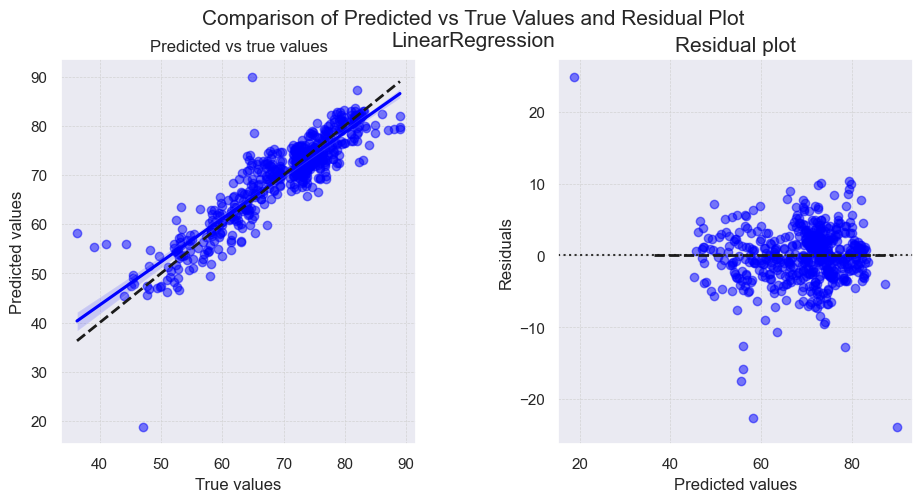

In [20]:
# Create instances of ModelComparisonPlot for each model
model_LR_plot = ModelComparisonPlot('LinearRegression')
# Plot comparison for each model
model_LR_plot.plot_comparison(y_val, y_pred, mse, mae, r2)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#2ae4f5''>7.2 |</span></b> Model 2: DecisionTreeRegressor </b></p>
</div>

In [21]:
model_DTR = DecisionTreeRegressor( max_depth = None,  max_features = None,  min_samples_leaf = 2,  min_samples_split = 10)
model_DTR.fit(scaled_x_train, y_train)
y_pred = model_DTR.predict(scaled_x_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Model: {type(model_DTR).__name__}, mse: {mse}")
print(f"Model: {type(model_DTR).__name__}, mae: {mae}")
print(f"Model: {type(model_DTR).__name__}, r2: {r2}")

Model: DecisionTreeRegressor, mse: 8.645256671404594
Model: DecisionTreeRegressor, mae: 1.8724878167641328
Model: DecisionTreeRegressor, r2: 0.8976859171764162


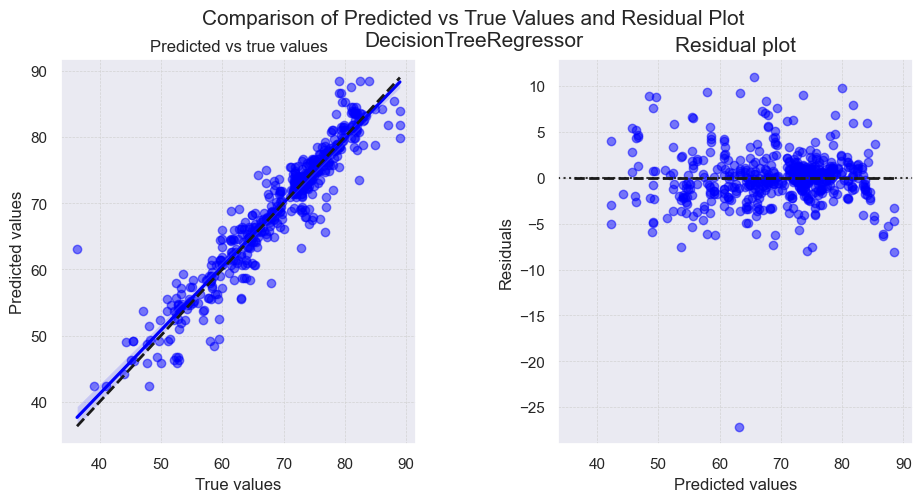

In [22]:
# Create instances of ModelComparisonPlot for each model
model_DTR_plot = ModelComparisonPlot('DecisionTreeRegressor')
# Plot comparison for each model
model_DTR_plot.plot_comparison(y_val, y_pred, mse, mae, r2)


<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#2ae4f5''>7.3 |</span></b> Model 3: RandomForestRegressor </b></p>
</div>

In [23]:
model_RFR = RandomForestRegressor(max_depth= 10, max_features= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)
model_RFR.fit(scaled_x_train, y_train)
y_pred = model_RFR.predict(scaled_x_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Model: {type(model_RFR).__name__}, mse: {mse}")
print(f"Model: {type(model_RFR).__name__}, mae: {mae}")
print(f"Model: {type(model_RFR).__name__}, r2: {r2}")

Model: RandomForestRegressor, mse: 5.629987946749642
Model: RandomForestRegressor, mae: 1.5791863351325812
Model: RandomForestRegressor, r2: 0.9333707401672859


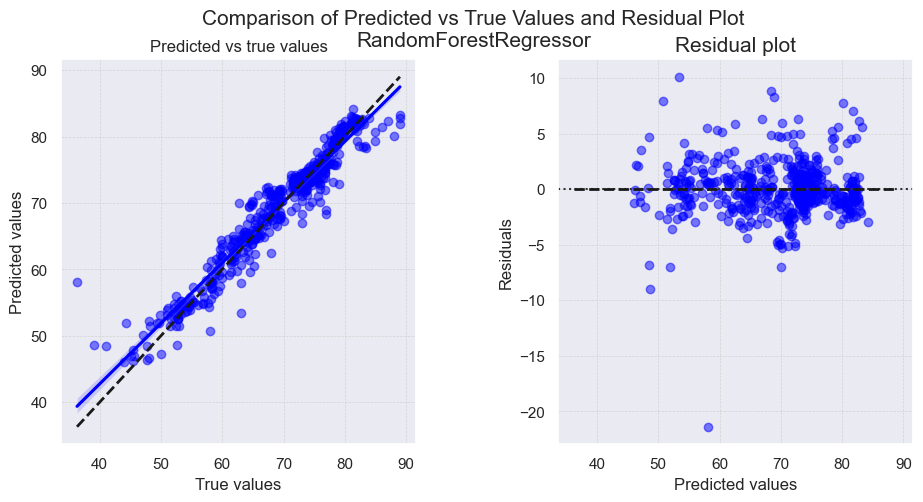

In [24]:
# Create instances of ModelComparisonPlot for each model
model_RFR_plot = ModelComparisonPlot('RandomForestRegressor')
# Plot comparison for each model
model_RFR_plot.plot_comparison(y_val, y_pred, mse, mae, r2)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#2ae4f5''>7.4 |</span></b> Model 4: GradientBoostingRegressor </b></p>
</div>

In [25]:
model_GBR = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 7, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 2, n_estimators= 200)
model_GBR.fit(scaled_x_train, y_train)
y_pred = model_GBR.predict(scaled_x_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Model: {type(model_GBR).__name__}, mse: {mse}")
print(f"Model: {type(model_GBR).__name__}, mae: {mae}")
print(f"Model: {type(model_GBR).__name__}, r2: {r2}")

Model: GradientBoostingRegressor, mse: 5.1098067207034
Model: GradientBoostingRegressor, mae: 1.4488024708841463
Model: GradientBoostingRegressor, r2: 0.9395269327556457


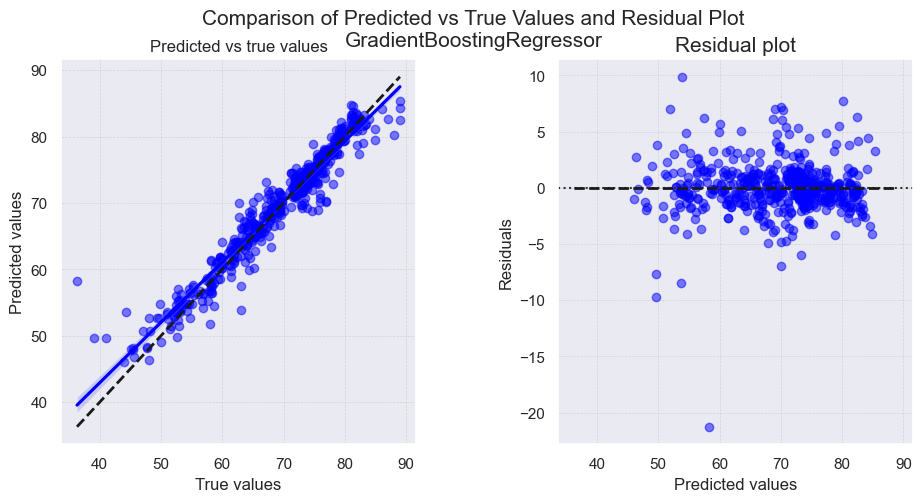

In [26]:
# Create instances of ModelComparisonPlot for each model
model_GBR_plot = ModelComparisonPlot('GradientBoostingRegressor')
# Plot comparison for each model
model_GBR_plot.plot_comparison(y_val, y_pred, mse, mae, r2)

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#2ae4f5''>7.5 |</span></b> Model 5: ExtraTreesRegressor </b></p>
</div>

In [27]:
model_ETR = ExtraTreesRegressor(max_depth= None, max_features= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)
model_ETR.fit(scaled_x_train, y_train)
y_pred = model_ETR.predict(scaled_x_val)
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Model: {type(model_ETR).__name__}, mse: {mse}")
print(f"Model: {type(model_ETR).__name__}, mae: {mae}")
print(f"Model: {type(model_ETR).__name__}, r2: {r2}")

Model: ExtraTreesRegressor, mse: 4.361881577777784
Model: ExtraTreesRegressor, mae: 1.199258479532163
Model: ExtraTreesRegressor, r2: 0.9483784079550165


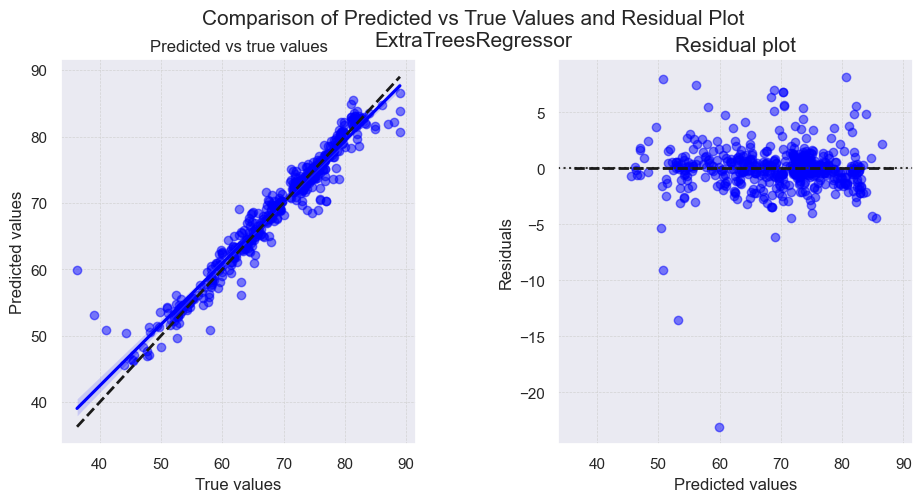

In [29]:
# Create instances of ModelComparisonPlot for each model
model_ETR_plot = ModelComparisonPlot('ExtraTreesRegressor')
# Plot comparison for each model
model_ETR_plot.plot_comparison(y_val, y_pred, mse, mae, r2)